In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from tqdm.auto import tqdm
import joblib
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
import time
from sklearn.metrics.pairwise import cosine_similarity
import smart_open
import gensim
import pickle
import os
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#os.chdir('/content/drive/My Drive/self_case_study1/data/VAE')

In [ ]:
# Sample data
#df = pd.read_csv('/content/drive/My Drive/StackOverflowData/sample-data.csv')
# Final data
df = pd.read_csv('/content/drive/MyDrive/StackOverflowData/data/all_data.csv')
# df.head()

In [ ]:
df.shape

(1088418, 7)

In [ ]:
# below mentioned functions are helper functions which is use for text preprocessing
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\n", "", phrase)
    return phrase

def remove_code(text):
    '''This function will remove code part and remove all html tags and return lower case text'''
    text = text.lower()
    # make it proper spaced text
    text = ' '.join(text.split())
    # remove code area from text and replace with space
    text = re.sub('<code>.*?</code>',' ',text)
    # remove all tags which are in "< >"
    text = re.sub('<.*?>',' ',text)
    # remove content between img tags
    text = re.sub('<img.*?>.*?</img>',' ',text)
    # remove content between a tag and URLs
    text = re.sub('<a.*?>.*?</a>',' ',text)
    # decontract text
    text = decontracted(text)
    # remove \n from text
    text = text.replace('\n',' ')
    # remove punctuations except c# and c++
    text = re.sub('[^A-Za-zc#c++]+',' ',text)
    return text.lower()

def remove_stopwords(text):
    '''this function will remove stopwords from text using nltk stopwords'''
    final_text = ''
    for word in text.split():
        if word not in stopwords.words('english'):
            final_text += word + ' '
    return final_text

def preprocess_text(text):
    '''this function will do all preprocessing'''
    # remove code part and punctuations
    removed_code = remove_code(text)
    # remove stopwords
    preprocessed_text = remove_stopwords(removed_code)
    # return cleaned text
    return preprocessed_text

def preprocess_title(text):
    # convert to lower case
    text = text.lower()
    # decontract
    text = decontracted(text)
    # remove all punctuations except a-z and c# and c++
    text = re.sub('[^a-zc#c++]+',' ',text)
    # remove stop words
    text = remove_stopwords(text)
    return text



* In Question body and answer body we have to remove code parts and we have to get only text part so we will remove code part and will remove html tags and all punctuations and we will get clean text in lower case.
*  We will add new column as preprocessed question body and preprocessed answer body.

In [ ]:
# remove code part from question body
removed_code_questions = []
for i,row in tqdm(df.iterrows()):
    removed_code_questions.append(remove_code(row.body))

0it [00:00, ?it/s]

In [ ]:
# remove stopwords from removed_code_questions
preprocessed_questions = []
for i in tqdm(removed_code_questions):
    preprocessed_questions.append(remove_stopwords(i))


  0%|          | 0/1088418 [00:00<?, ?it/s]

In [ ]:
# preprocess title
preprocessed_title = []
for i,row in tqdm(df.iterrows()):
    preprocessed_title.append(preprocess_title(row.title))

0it [00:00, ?it/s]

In [ ]:
# original title
df['title'][2]

'JavaScript Troubleshooting Tools in Internet Explorer'

In [ ]:
# cleaned title
preprocessed_title[2]

'javascript troubleshooting tools internet explorer '

In [ ]:
# remove code from answers
removed_code_answers = []
for row in tqdm(df['answers']):
    removed_code_answers.append(remove_code(row))

  0%|          | 0/1088418 [00:00<?, ?it/s]

In [ ]:
# original answer at index 0
df['answers'][0]

'<p>I don\'t understand why you would want to do this. It sounds almost like cargo cult coding.</p>\n\n<p>Converting a CSV file to XML doesn\'t add any value. Your program is already reading the CSV file, so arguing that you need XML doesn\'t work.</p>\n\n<p>On the other hand, reading the CSV file, doing <em>something</em> with the values, and then serializing to XML does make sense (well, as much as using XML can make sense... ;)) but you would supposedly already have a means of serializing to XML.</p>\n<p>Jackson processor family has backends for multiple data formats, not just JSON. This includes both XML (<a href="https://github.com/FasterXML/jackson-dataformat-xml" rel="noreferrer">https://github.com/FasterXML/jackson-dataformat-xml</a>) and CSV (<a href="https://github.com/FasterXML/jackson-dataformat-csv/" rel="noreferrer">https://github.com/FasterXML/jackson-dataformat-csv/</a>) backends.</p>\n\n<p>Conversion would rely on reading input with CSV backend, write using XML backend

In [ ]:
# answers after removing code
removed_code_answers[0]

' i do not understand why you would want to do this it sounds almost like cargo cult coding converting a csv file to xml does not add any value your program is already reading the csv file so arguing that you need xml does not work on the other hand reading the csv file doing something with the values and then serializing to xml does make sense well as much as using xml can make sense but you would supposedly already have a means of serializing to xml jackson processor family has backends for multiple data formats not just json this includes both xml https github com fasterxml jackson dataformat xml and csv https github com fasterxml jackson dataformat csv backends conversion would rely on reading input with csv backend write using xml backend this is easiest to do if you have or can define a pojo for per row csv entries this is not a strict requirement as content from csv may be read untyped as well a sequence of arrays but requires bit more work on xml output for xml side you would n

In [ ]:
# remove stopwords from answers
preprocessed_answers = []
for i in tqdm(removed_code_answers):
    preprocessed_answers.append(remove_stopwords(i))

  0%|          | 0/1088418 [00:00<?, ?it/s]

In [ ]:
df['answers'][0]

'<p>I don\'t understand why you would want to do this. It sounds almost like cargo cult coding.</p>\n\n<p>Converting a CSV file to XML doesn\'t add any value. Your program is already reading the CSV file, so arguing that you need XML doesn\'t work.</p>\n\n<p>On the other hand, reading the CSV file, doing <em>something</em> with the values, and then serializing to XML does make sense (well, as much as using XML can make sense... ;)) but you would supposedly already have a means of serializing to XML.</p>\n<p>Jackson processor family has backends for multiple data formats, not just JSON. This includes both XML (<a href="https://github.com/FasterXML/jackson-dataformat-xml" rel="noreferrer">https://github.com/FasterXML/jackson-dataformat-xml</a>) and CSV (<a href="https://github.com/FasterXML/jackson-dataformat-csv/" rel="noreferrer">https://github.com/FasterXML/jackson-dataformat-csv/</a>) backends.</p>\n\n<p>Conversion would rely on reading input with CSV backend, write using XML backend

In [ ]:
preprocessed_answers[0]

'understand would want sounds almost like cargo cult coding converting csv file xml add value program already reading csv file arguing need xml work hand reading csv file something values serializing xml make sense well much using xml make sense would supposedly already means serializing xml jackson processor family backends multiple data formats json includes xml https github com fasterxml jackson dataformat xml csv https github com fasterxml jackson dataformat csv backends conversion would rely reading input csv backend write using xml backend easiest define pojo per row csv entries strict requirement content csv may read untyped well sequence arrays requires bit work xml output xml side would need wrapper root object contain array objects serialize solution need csv xml libraries know handle illegal characters encoding issues might interested well provided csv input break mentioned rules attention use code unless know chance use library possible bureaucratic projects use stringbuffe

In [ ]:
# dump preprocessed question drive
joblib.dump(preprocessed_questions,'/content/drive/MyDrive/StackOverflowData/pretrain_data_all/preprocessed_questions')

NameError: name 'preprocessed_questions' is not defined

In [ ]:
# dump preprocessed title in drive
joblib.dump(preprocessed_title,'/content/drive/MyDrive/StackOverflowData/pretrain_data_all/preprocessed_title')

['/content/drive/MyDrive/StackOverflowData/pretrain_data_all/preprocessed_title']

In [ ]:
# dump preprocessed answers in drive
joblib.dump(preprocessed_answers,'/content/drive/MyDrive/StackOverflowData/pretrain_data_all/preprocessed_answers')

['/content/drive/MyDrive/StackOverflowData/pretrain_data_all/preprocessed_answers']

In [ ]:
# load preprocessed questions
preprocessed_question = joblib.load('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/preprocessed_questions')

In [ ]:
print('Length of preprocessed questions = ',len(preprocessed_question))

Length of preprocessed questions =  1088418


In [ ]:
# load preprocessed titles
preprocessed_title = joblib.load('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/preprocessed_title')

In [ ]:
print('Length of preprocessed titles= ',len(preprocessed_title))

Length of preprocessed titles=  1088418


In [ ]:
# load preprocessed answers
preprocessed_answer = joblib.load('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/preprocessed_answers')

In [ ]:
print('Length of preprocessed answers= ',len(preprocessed_answer))

Length of preprocessed answers=  1088418


In [ ]:
tags = df['tags']
id = df['id']
score = df['score']

In [ ]:
Dict = { 'id' : id,
         'preprocessed_title' : preprocessed_title,
         'preprocessed_question': preprocessed_question,
         'preprocessed_answer' : preprocessed_answer,
         'score' : score,
         'tags': tags}
preprocessed_df = pd.DataFrame(Dict)

In [ ]:
# save as csv
preprocessed_df.to_csv('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/preprocessed_df.csv',index=False)

## Load preprocesed data

In [ ]:
preprocessed_df = pd.read_csv('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/preprocessed_df.csv')
# preprocessed_df.head()

In [ ]:
len(preprocessed_df)

1088418

In [ ]:
# cheking for null values
print('Total null values in preprocessed titles =',preprocessed_df['preprocessed_title'].isna().sum())
print('Total null values in preprocessed questions =',preprocessed_df['preprocessed_question'].isna().sum())
print('Total null values in preprocessed answers =',preprocessed_df['preprocessed_answer'].isna().sum())
print('Total null values in score =',preprocessed_df['score'].isna().sum())
print('Total null values in tags =',preprocessed_df['tags'].isna().sum())

Total null values in preprocessed titles = 18
Total null values in preprocessed questions = 923
Total null values in preprocessed answers = 6276
Total null values in score = 0
Total null values in tags = 0


In [ ]:
# concatenate title and question body
preprocessed_df['question_content'] = preprocessed_df['preprocessed_title'].fillna('') + ' ' + preprocessed_df['preprocessed_question'].fillna('')

In [ ]:
# remove all character  which has length 1
def remove_single_char(text):
    l = [word for word in str(text).split() if len(word) > 1]
    return ' '.join(l)

In [ ]:
# remove words with length 1 from question content and answer
preprocessed_df['question_content'] = preprocessed_df['question_content'].apply(lambda x: remove_single_char(x))
preprocessed_df['preprocessed_answer'] = preprocessed_df['preprocessed_answer'].apply(lambda x: remove_single_char(x))

In [ ]:
# concatenate question content and preprocessed answer
preprocessed_df['all_text'] = preprocessed_df['question_content'].fillna('')+' '+preprocessed_df['preprocessed_answer'].fillna('')

In [ ]:
preprocessed_df.head()

,id,preprocessed_title,preprocessed_question,preprocessed_answer,score,tags,question_content,all_text
0,11227809,processing sorted array faster processing unso...,piece c++ code shows peculiar behavior strange...,victim branch prediction fail branch predictio...,26621,java|c++|performance|cpu-architecture|branch-p...,processing sorted array faster processing unso...,processing sorted array faster processing unso...
1,927358,undo recent local commits git,accidentally committed wrong files git push co...,undo commit amp redo command responsible undo ...,24809,git|version-control|git-commit|undo,undo recent local commits git accidentally com...,undo recent local commits git accidentally com...
2,2003505,delete git branch locally remotely,failed attempts delete remote branch properly ...,executive summary note cases delete local bran...,19556,git|version-control|git-branch|git-push|git-re...,delete git branch locally remotely failed atte...,delete git branch locally remotely failed atte...
3,292357,difference git pull git fetch,differences,simplest terms followed updates remote trackin...,13368,git|version-control|git-pull|git-fetch,difference git pull git fetch differences,difference git pull git fetch differences simp...
4,231767,yield keyword,use keyword python example trying understand c...,understand must understand generators understa...,12259,python|iterator|generator,yield keyword use keyword python example tryin...,yield keyword use keyword python example tryin...


#### Checking for null values in question content

In [ ]:
# checking in preprocessed_df for null titles
preprocessed_df['question_content'].isna().sum()

0

#### Checking for null values in all text

In [ ]:
# checking in preprocessed_df for null answers
preprocessed_df['all_text'].isna().sum()

0

In [ ]:
preprocessed_df['all_text'][0]

'java lib app convert csv xml file existing application library java allow convert data file file tags would provided possibly first row containing column headings understand would want sounds almost like cargo cult coding converting csv file xml add value program already reading csv file arguing need xml work hand reading csv file something values serializing xml make sense well much using xml make sense would supposedly already means serializing xml jackson processor family backends multiple data formats json includes xml https github com fasterxml jackson dataformat xml csv https github com fasterxml jackson dataformat csv backends conversion would rely reading input csv backend write using xml backend easiest define pojo per row csv entries strict requirement content csv may read untyped well sequence arrays requires bit work xml output xml side would need wrapper root object contain array objects serialize solution need csv xml libraries know handle illegal characters encoding iss

# Analysis of question content

In [ ]:
# import FreqDist from nltk library to get word frequency from given text
from nltk import FreqDist

In [ ]:
# get one single list of whole corpus words
all_words = []
for line in tqdm(preprocessed_df['question_content']):
    all_words.extend(line.split())

  0%|          | 0/1088418 [00:00<?, ?it/s]

In [ ]:
# get frequency distribution of all words
word_freq = FreqDist(all_words)
print('Number of unique words = ',len(word_freq))

Number of unique words =  517328


In [ ]:
# cheecking last 5 words from most common words
word_freq.most_common(20000)[-5:]

[('speechsynthesis', 44),
 ('channelid', 44),
 ('xychart', 44),
 ('loadingcache', 44),
 ('acr', 44)]

here we are taking top 20000 words because last 5 words of top 20000 words are occuring atleasr 30 times

In [ ]:
# top 20000 words
top_k_words = dict(word_freq.most_common(20000)).keys()

In [ ]:
# set of top k words
top_k_words = set(top_k_words)
print('Length of top k words is = ', len(top_k_words))

Length of top k words is =  20000


In [ ]:
def keep_top_k_words(text):
    ''' This function will keep only top k words'''
    top_k =  [word for word in text.split() if word in top_k_words]
    return ' '.join(top_k)

In [ ]:
# apply keep top words function on question content
preprocessed_df['question_content'] = preprocessed_df['question_content'].apply(lambda x : keep_top_k_words(x))

### Analysis on question content length

In [ ]:
# make column of question content length
preprocessed_df['question_length'] = preprocessed_df['question_content'].apply(lambda x: len(x.split()))

In [ ]:
preprocessed_df.head()

,id,preprocessed_title,preprocessed_question,preprocessed_answer,score,tags,question_content,all_text,question_length
0,11227809,processing sorted array faster processing unso...,piece c++ code shows peculiar behavior strange...,victim branch prediction fail branch predictio...,26621,java|c++|performance|cpu-architecture|branch-p...,processing sorted array faster processing unso...,processing sorted array faster processing unso...,106
1,927358,undo recent local commits git,accidentally committed wrong files git push co...,undo commit amp redo command responsible undo ...,24809,git|version-control|git-commit|undo,undo recent local commits git accidentally com...,undo recent local commits git accidentally com...,18
2,2003505,delete git branch locally remotely,failed attempts delete remote branch properly ...,executive summary note cases delete local bran...,19556,git|version-control|git-branch|git-push|git-re...,delete git branch locally remotely failed atte...,delete git branch locally remotely failed atte...,15
3,292357,difference git pull git fetch,differences,simplest terms followed updates remote trackin...,13368,git|version-control|git-pull|git-fetch,difference git pull git fetch differences,difference git pull git fetch differences simp...,6
4,231767,yield keyword,use keyword python example trying understand c...,understand must understand generators understa...,12259,python|iterator|generator,yield keyword use keyword python example tryin...,yield keyword use keyword python example tryin...,38


In [ ]:
preprocessed_df.shape

(1088418, 9)

In [ ]:
print('50th percentile of question lenght is ==>',np.percentile(preprocessed_df['question_length'],50))
print('75th percentile of question lenght is ==>',np.percentile(preprocessed_df['question_length'],75))
print('90th percentile of question lenght is ==>',np.percentile(preprocessed_df['question_length'],90))
print('95th percentile of question lenght is ==>',np.percentile(preprocessed_df['question_length'],95))
print('98th percentile of question lenght is ==>',np.percentile(preprocessed_df['question_length'],98))

50th percentile of question lenght is ==> 21.0
75th percentile of question lenght is ==> 35.0
90th percentile of question lenght is ==> 59.0
95th percentile of question lenght is ==> 91.04999999999995
98th percentile of question lenght is ==> 133.13999999999987


## plot CDF of question length

<Axes: xlabel='question_length', ylabel='Density'>

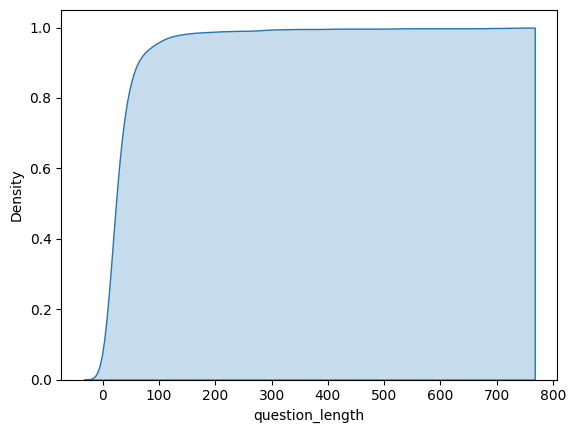

In [ ]:
import seaborn as sns
sns.kdeplot(preprocessed_df['question_length'],cumulative=True,shade=True)

### as we can see 75th percent of question length are 60 or less then 60 so we will consider all questions which have length less then or equal to 60.

In [ ]:
print('Total number of rows which have question length greater then 60 is  =======>')
print(preprocessed_df[preprocessed_df['question_length']>60].shape[0])

Total number of rows which have question length greater then 60 is  =======>
90


In [ ]:
preprocessed_df = preprocessed_df[preprocessed_df['question_length']<60]
print('Total number of rows in preprocessed_df after dropping large length question = ', preprocessed_df.shape[0])

Total number of rows in preprocessed_df after dropping large length question =  904


In [ ]:
# reset index
preprocessed_df.reset_index(drop=True,inplace=True)

In [ ]:
preprocessed_df.head()

,id,preprocessed_title,preprocessed_question,preprocessed_answer,score,tags,question_content,all_text,question_length
0,927358,undo recent local commits git,accidentally committed wrong files git push co...,undo commit amp redo command responsible undo ...,24809,git|version-control|git-commit|undo,undo recent local commits git accidentally com...,undo recent local commits git accidentally com...,18
1,2003505,delete git branch locally remotely,failed attempts delete remote branch properly ...,executive summary note cases delete local bran...,19556,git|version-control|git-branch|git-push|git-re...,delete git branch locally remotely failed atte...,delete git branch locally remotely failed atte...,15
2,292357,difference git pull git fetch,differences,simplest terms followed updates remote trackin...,13368,git|version-control|git-pull|git-fetch,difference git pull git fetch differences,difference git pull git fetch differences simp...,6
3,231767,yield keyword,use keyword python example trying understand c...,understand must understand generators understa...,12259,python|iterator|generator,yield keyword use keyword python example tryin...,yield keyword use keyword python example tryin...,38
4,477816,json content type use,many quot standards quot json content type one...,json text mime media type json text default en...,11267,json|mime-types|content-type,json content type use many quot standards quot...,json content type use many quot standards quot...,26


In [ ]:
# save final featurized dataframe
preprocessed_df.to_csv('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/featurized_df.csv',index=False)

In [ ]:
featurized_df = pd.read_csv('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/featurized_df.csv')

In [ ]:
print('Shape of featurized_df is ===> ',featurized_df.shape)

Shape of featurized_df is ===>  (1088418, 9)


In [ ]:
featurized_df.head(3)

,id,preprocessed_title,preprocessed_question,preprocessed_answer,score,tags,question_content,all_text,question_length
0,123,java lib app convert csv xml file,existing application library java allow conver...,understand would want sounds almost like cargo...,299,java|xml|csv|data-conversion,java lib app convert csv xml file existing app...,java lib app convert csv xml file existing app...,25
1,845,detect one defined font used web page,suppose following css rule page could detect o...,using fount drag fount button bookmarks bar cl...,184,javascript|html|css|fonts,detect one defined font used web page suppose ...,detect one defined font used web page suppose ...,55
2,3404,javascript troubleshooting tools internet expl...,use firebug mozilla js console heavily every r...,use microsoft script debugger firebug lite dep...,65,javascript|internet-explorer|debugging,javascript troubleshooting tools internet expl...,javascript troubleshooting tools internet expl...,50


In [ ]:
# create dataframe of original title and id
title_df = df[['id','title']]
title_df.head()

,id,title
0,123,Java lib or app to convert CSV to XML file?
1,845,How to detect which one of the defined font wa...
2,3404,JavaScript Troubleshooting Tools in Internet E...
3,3713,Call ASP.NET function from JavaScript?
4,4630,"How can I Java webstart multiple, dependent, n..."


In [ ]:
# attach original title column using merge operation on id

featurized_df = featurized_df.merge(title_df,on='id')

In [ ]:
featurized_df.head(2)

,id,preprocessed_title,preprocessed_question,preprocessed_answer,score,tags,question_content,all_text,question_length,title
0,123,java lib app convert csv xml file,existing application library java allow conver...,understand would want sounds almost like cargo...,299,java|xml|csv|data-conversion,java lib app convert csv xml file existing app...,java lib app convert csv xml file existing app...,25,Java lib or app to convert CSV to XML file?
1,845,detect one defined font used web page,suppose following css rule page could detect o...,using fount drag fount button bookmarks bar cl...,184,javascript|html|css|fonts,detect one defined font used web page suppose ...,detect one defined font used web page suppose ...,55,How to detect which one of the defined font wa...


### Save final featurized data with original title as csv

In [ ]:
# save final dataframe
featurized_df.to_csv('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/featurized_data.csv',index=False)

#### Load featurized dataframe

In [ ]:
# load final featurized dataframe
featurized_df = pd.read_csv('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/featurized_data.csv')

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test = train_test_split(featurized_df,test_size=0.5,random_state=42)

# reset index of train and test
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

print('Shape of X_train',X_train.shape)
print('Shape of X_test',X_test.shape)

Shape of X_train (544209, 10)
Shape of X_test (544209, 10)


In [ ]:
X_train.head()

,id,preprocessed_title,preprocessed_question,preprocessed_answer,score,tags,question_content,all_text,question_length,title
0,67187120,keep getting error location null,working app method called postcar called creat...,reason fusedapi working using google maps proj...,0,java|android|firebase|geofire,keep getting error location null working app m...,keep getting error location null working app m...,58,i keep getting an error that location is null
1,26228568,load javascript clicks website,javascript want load user clicked two times we...,start showing alert nd click write code load j...,1,javascript,load javascript clicks website javascript want...,load javascript clicks website javascript want...,15,Load javascript after 2 clicks on website
2,70255431,js spread operator workflow react,react suggests mutate state array objects mani...,code mutating original object reference creati...,1,javascript|reactjs|immutability|spread,js spread operator workflow react react sugges...,js spread operator workflow react react sugges...,41,JS spread operator workflow on React
3,2185823,start local port user computer edited question,sorry past able formulate question coherently ...,applet basically piece java code served webpag...,2,java|php|python|c|localhost,start local port user computer edited question...,start local port user computer edited question...,58,How to start a local port on user's computer (...
4,5560885,pop showing tab ie need window,know someone else asked recently seen answer y...,put object element iframe div tricked look act...,1,javascript|internet-explorer|popup,pop showing tab ie need window know someone el...,pop showing tab ie need window know someone el...,46,Pop-up is showing in tab on IE8 but I need it ...


### **Model-1 : TFIDF word2vec using pretrained glove model**

In [ ]:
# function to load glove vectors
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('/content/drive/MyDrive/StackOverflowData/Model/Glove/glove.42B.300d.txt')

Loading Glove Model


0it [00:00, ?it/s]

Done. 1917494  words loaded!


In [ ]:
X_train['question_content'] = X_train['question_content'].fillna('')

In [ ]:
# get list of lists for every sentence words
words = []
for line in tqdm(X_train['question_content']):
    words.append(line.split())

  0%|          | 0/544209 [00:00<?, ?it/s]

In [ ]:
len(words)

544209

In [ ]:
# get one single list of whole corpus words
Words = []
for line in tqdm(X_train['question_content']):
    Words.extend(line.split())

  0%|          | 0/544209 [00:00<?, ?it/s]

In [ ]:
print("All the words in the courpus", len(Words))
Words = set(Words)
print("The unique words in the courpus", len(Words))
inter_words = set(model.keys()).intersection(Words)
print("The number of words that are present in both glove vectors and our courpus", \
len(inter_words),"(",np.round(len(inter_words)/len(Words)*100,3),"%)")

All the words in the courpus 26852877
The unique words in the courpus 19970
The number of words that are present in both glove vectors and our courpus 17840 ( 89.334 %)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=10)
# fit and transform on question content
tfidf.fit_transform(X_train["question_content"])

<544209x19474 sparse matrix of type '<class 'numpy.float64'>'
	with 18916200 stored elements in Compressed Sparse Row format>

In [ ]:
# save tfidf
joblib.dump(tfidf,'/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps_glove_model/tfidf1')

['/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps_glove_model/tfidf1']

In [ ]:
tfidf_words = tfidf.get_feature_names_out()
len(tfidf_words)

19474

In [ ]:
words_courpus = {}
words_glove = set(model.keys())
for i in Words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps_glove_model/glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


word 2 vec length 17840


## load glove vectors

In [ ]:
with open('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps_glove_model/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words = set(model.keys())

In [ ]:
# we are converting a dictionary with word as a key, and the idf as a value
tfidf = joblib.load('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps_glove_model/tfidf1')
dictionary = dict(zip(tfidf.get_feature_names_out(), list(tfidf.idf_)))
tfidf_words = set(tfidf.get_feature_names_out())

In [ ]:

tfidf_w2v_vector = [] # the weighted w2v for each sentence is stored in this list
for sentence in tqdm(words): # for each sentence words list
    vector = np.zeros(300) # as word vectors length is 300
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence : # for each word in a review/sentence
        if (word in glove_words ) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # multiply idf value of word with tf of word
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence))
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vector.append(vector)

  0%|          | 0/544209 [00:00<?, ?it/s]

In [ ]:
# save tfidf w2v vectors
joblib.dump(tfidf_w2v_vector,'/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps_glove_model/tfidf_w2v_vector_glove')

['/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps_glove_model/tfidf_w2v_vector_glove']

In [ ]:
# load tfidf w2v vectors
tfidf_w2v_vector = joblib.load('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps_glove_model/tfidf_w2v_vector_glove')

In [ ]:
# query question
text = 'How do I delete a Git branch locally and remotely'
text

'How do I delete a Git branch locally and remotely'

In [ ]:
# get glove words
#glove_words = set(model.keys())
# get tfidf words
#tfidf_words = set(tfidf.get_feature_names())
# dictionary of tfidf
#dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))


def find_similarity(question,top_n):
    ''' This function will find top similar result for given query'''
    start = time.time()
    # initialize  vector for user query
    main_vec = np.zeros(300)
    # initialize tfidf weight tổng hợp tfidf
    weight_sum = 0
    # preprocess question
    text = preprocess_title(question)
    #splitting the sentence
    text_list = list(text.split())
    # Tạo vector đại diện cho câu hỏi đầu vào
    for word in text_list:
        #finding if word is present in tfidf and in w2v words
        if word in tfidf_words and word in glove_words :
            #finding vector of word from glove model
            vect = model[word]
            #compute tfidf
            tf_idf = dictionary[word]*(text_list.count(word)/len(text_list))
            # adding vector * tfidf to main_vec
            main_vec+= (vect*tf_idf)
            # summing tfidf values
            weight_sum += tf_idf
    if weight_sum !=0:
        # devide by weight_sum
        main_vec /= weight_sum
    # find cosine similarity
    similarities =  cosine_similarity((main_vec).reshape(1, -1), Y=tfidf_w2v_vector, dense_output=True)
    # sort similarities
    #print(similarities[0])

    sort = np.argsort(similarities[0])
    # get top similarity indices  in descending order
    similarity_index = np.array(list(reversed(sort)))
    # finad top n similarities
    top_similarity_index = similarity_index[:top_n]
    # print top similarity values
    print('Top cosine similarities are ======>',similarities[0][top_similarity_index])
    # get original title of similar questions
    similar_questions = X_train['title'][top_similarity_index]
    #print(similar_questions)

    similar_question_list = []
    for q in similar_questions:
        similar_question_list.append(q)
        #print(q)
    total_time = (time.time() - start)
    print('Total time ===========> ',total_time)
    return similar_question_list


In [ ]:
top_10_questions = find_similarity(text,10)

Top cosine similarities are ======> [0.86018831 0.85467599 0.85353088 0.84241286 0.83856049 0.83855645
 0.8349499  0.83302747 0.83099641 0.82686268]
Total time ===========>  2.1859822273254395


In [ ]:
print('Top 10 similar questions Using weighted TFIDF and Glove vectors')
print('='*100)
print('\t')
for i,line in enumerate(top_10_questions):
    print('Question {} ===> {}'.format(i+1,line))
    print('='*100)

Top 10 similar questions Using weighted TFIDF and Glove vectors
	
Question 1 ===> Authenticate subversion remotely
Question 2 ===> Retrieving Branches from GIT url using java code
Question 3 ===> How to remove remote branch with JGit
Question 4 ===> How to prevent node js from serving .git folders and all the files under .git
Question 5 ===> What are the things should be considered while using git using console while developement using IDE(Eclipse)?
Question 6 ===> Create a new local repo from existing project
Question 7 ===> Run Git commands and parse log History from java Program
Question 8 ===> Jenkins Git Client Plugin fails FetchCommand execution
Question 9 ===> JGit CheckoutCommand does not work
Question 10 ===> Use Java to validate a remote repository


# Model-2 : train word2vec using gensim

In [ ]:
from gensim.models import Word2Vec

In [ ]:
words

[['keep',
  'getting',
  'error',
  'location',
  'null',
  'working',
  'app',
  'method',
  'called',
  'called',
  'create',
  'add',
  'child',
  'firebase',
  'consoles',
  'table',
  'child',
  'contains',
  'user',
  'id',
  'location',
  'problem',
  'location',
  'keeps',
  'getting',
  'marked',
  'null',
  'code',
  'method',
  'reads',
  'quot',
  'setlocation',
  'userid',
  'new',
  'geolocation',
  'quot',
  'keeps',
  'throwing',
  'error',
  'quot',
  'attempt',
  'invoke',
  'virtual',
  'method',
  'wouldouble',
  'android',
  'location',
  'location',
  'null',
  'object',
  'reference',
  'quot',
  'devices',
  'location',
  'check',
  'location',
  'permissions',
  'code'],
 ['load',
  'javascript',
  'clicks',
  'website',
  'javascript',
  'want',
  'load',
  'user',
  'clicked',
  'two',
  'times',
  'website',
  'clue',
  'suggestions',
  'thanks'],
 ['js',
  'spread',
  'operator',
  'workflow',
  'react',
  'react',
  'suggests',
  'mutate',
  'state',
  'ar

In [ ]:
# train Word2vec model with vector size 60
w2v_model = Word2Vec(words, vector_size=60, min_count=10, workers=-1, epochs=50)

In [ ]:
word_vectors = w2v_model.wv

In [ ]:
# shape of w2v vectors
word_vectors.vectors.shape

(19934, 60)

In [ ]:
# save word2vec model
joblib.dump(w2v_model,'/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps/gensim_w2v_model')

['/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps/gensim_w2v_model']

In [ ]:
print(gensim.__version__)

4.3.3


In [ ]:
# get word2vec vocab
w2v_words = list(w2v_model.wv.index_to_key)
print("sample words =====>", w2v_words[0:10])

sample words =====> ['code', 'using', 'java', 'like', 'get', 'want', 'file', 'use', 'would', 'javascript']


In [ ]:
# number of unique word in word2vec vocab
print('Number of unique words in Word2vec ==> ',len(w2v_words))

Number of unique words in Word2vec ==>  19934


In [ ]:
# Words list have all the words which are in corpus
print("All the words in the courpus", len(Words))
# unique words from whole X_train
Words = set(Words)
print("The unique words in the courpus", len(Words))
# common word of w2v_words and Words
inter_words = set(w2v_words).intersection(Words)
print("The number of words that are present in both glove vectors and our courpus", \
len(inter_words),"(",np.round(len(inter_words)/len(Words)*100,3),"%)")

All the words in the courpus 19970
The unique words in the courpus 19970
The number of words that are present in both glove vectors and our courpus 19934 ( 99.82 %)


### **TF-IDF weighted W2V using gensim**

In [ ]:
# dictionary in which word as key and idf as value
dictionary = dict(zip(tfidf.get_feature_names_out(),tfidf.idf_))
print("Sample dictionary: ", list(dictionary.items())[:10])

Sample dictionary:  [('aa', 8.230739571461726), ('aaa', 8.898822783358455), ('aaaa', 10.315270182649034), ('aaaaa', 11.116048027401344), ('aab', 10.741354577959934), ('aabb', 11.434501758519879), ('aac', 10.400427990989341), ('aad', 10.948993942738179), ('aapl', 11.26265150159322), ('aapt', 10.569504321033275)]


In [ ]:
# check for random word
dictionary['javascript']

2.711830129196999

In [ ]:
# number of words in dictionary
len(dictionary)

19474

In [ ]:
# get tfidf words
tfidf_words = set(tfidf.get_feature_names_out())

In [ ]:
tfidf_w2v_vectors_gensim = [] # the weighted w2v for each sentence is stored in this list
for sentence in tqdm(words): # for each sentence
    vector = np.zeros(60) # as word vectors length is 60
    tf_idf_weight =0; # num of words with a valid vector in the sentence
    for word in sentence : # for each word in a review/sentence
        if (word in w2v_words) and (word in tfidf_words):
            vec = w2v_model.wv[word] # getting the vector for each word
            # multiply idf value of word with tf of word
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence))
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_gensim.append(vector)


  0%|          | 0/544209 [00:00<?, ?it/s]

In [ ]:
len(tfidf_w2v_vectors_gensim)

544209

In [ ]:
# save tfidf w2v vectors using gensim
joblib.dump(tfidf_w2v_vectors_gensim,'/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps/tfidf_w2v_vectors_gensim')

['/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps/tfidf_w2v_vectors_gensim']

In [ ]:
# total number of vectors
print('Total number of vectors = ',len(tfidf_w2v_vectors_gensim))
# length of single vector
print('Size of single vector = ',len(tfidf_w2v_vectors_gensim[0]))

Total number of vectors =  544209
Size of single vector =  60


##### **Load all saved files**

In [ ]:
tfidf_gensim = joblib.load('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps_glove_model/tfidf1')
w2v_model_gensim = joblib.load('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps/gensim_w2v_model')
tfidf_w2v_vectors_gensim = joblib.load('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/joblib_dumps/tfidf_w2v_vectors_gensim')

In [ ]:
# w2vec words vocabulary
w2v_words = list(w2v_model_gensim.wv.index_to_key)
# tfidf words
tfidf_words = set(tfidf_gensim.get_feature_names_out())
# dictionary of tfidf and idf values
dictionary = dict(zip(tfidf_gensim.get_feature_names_out(),tfidf_gensim.idf_))

In [ ]:
text = 'How do I delete a Git branch locally and remotely'

In [ ]:
def find_similarity_gensim_trained(question,top_n):
    ''' This function will find top similar result for given query using gensim w2v'''
    start = time.time()
    # initialize  vector for user query
    main_vec = np.zeros(60)
    # initialize tfidf weight
    weight_sum = 0
    # preprocess question
    text = preprocess_title(question)
    #splitting the sentence
    text_list = list(text.split())
    for word in text_list:
        #finding if word is present in tfidf and in w2v words
        if word in tfidf_words and word in w2v_words :
            #finding vector of word from glove model
            vect = w2v_model_gensim.wv[word]
            #compute tfidf
            tf_idf = dictionary[word]*(text_list.count(word)/len(text_list))
            # adding vector * tfidf to main_vec
            main_vec+= (vect*tf_idf)
            # summing tfidf values
            weight_sum += tf_idf
    if weight_sum !=0:
        # devide by weight_sum
        main_vec /= weight_sum
    # find cosine similarity
    # tfidf word2vec have trained using gensim
    similarities =  cosine_similarity((main_vec).reshape(1, -1), Y=tfidf_w2v_vectors_gensim, dense_output=True)
    # sort similarities
    sort = np.argsort(similarities[0])
    # get top similarity indices  in descending order
    similarity_index = np.array(list(reversed(sort)))
    # find top n similarities
    top_similarity_index = similarity_index[:top_n]
    # print top similarity values
    print('Top cosine similarities are ======>',similarities[0][top_similarity_index])
    similar_questions = X_train['title'][top_similarity_index]
    #print(similar_questions)
    similar_question_list = []
    for q in similar_questions:
        similar_question_list.append(q)
        #print(q)
    total_time = (time.time() - start)
    print('\t')
    print('Total time ===========> ',total_time)
    return similar_question_list

In [ ]:
top_10_similar_q = find_similarity_gensim_trained(text,10)

Top cosine similarities are ======> [0.66548341 0.64129989 0.59415437 0.57168188 0.56602133 0.56453004
 0.564435   0.55512318 0.55343616 0.55194651]
	
Total time ===========>  0.6778848171234131


In [ ]:
print('Top 10 similar questions Using weighted TFIDF and gensim Word2Vec')
print('='*100)
print('\t')
for i,line in enumerate(top_10_similar_q):
    print('Question {} ===> {}'.format(i+1,line))
    print('='*100)

Top 10 similar questions Using weighted TFIDF and gensim Word2Vec
	
Question 1 ===> Retrieving Branches from GIT url using java code
Question 2 ===> Authenticate subversion remotely
Question 3 ===> In Spring WebFlux, How to chaining methods from multiple services/repo, in order to 'delete' elements in multiples DB-Collections'?
Question 4 ===> What are the things should be considered while using git using console while developement using IDE(Eclipse)?
Question 5 ===> Converting e.timeStamp into the current date/time?
Question 6 ===> How to make the ball bounce off the walls in JavaFX?
Question 7 ===> The method onClick(View) from the type new Thread(){} is never used locally
Question 8 ===> How to delete nested element in map Immutable.js
Question 9 ===> Can Firebase Messaging Service be a scalable replacement to websockets / server sent events?
Question 10 ===> Open git bash using processBuilder and execute command in it


# Model-3 : Doc2Vec
Reference : https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

**There are two implementations:**

    1. Paragraph Vector - Distributed Memory (PV-DM)

    2. Paragraph Vector - Distributed Bag of Words (PV-DBOW)

In [ ]:
def read_corpus(filename, tokens_only=False):
    for i, line in tqdm(enumerate(filename)):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])


In [ ]:
# train corpus
train_corpus = list(read_corpus(X_train['question_content']))

0it [00:00, ?it/s]

In [ ]:
# check for first 5 questions
train_corpus[:5]

[TaggedDocument(words=['keep', 'getting', 'error', 'location', 'null', 'working', 'app', 'method', 'called', 'called', 'create', 'add', 'child', 'firebase', 'consoles', 'table', 'child', 'contains', 'user', 'id', 'location', 'problem', 'location', 'keeps', 'getting', 'marked', 'null', 'code', 'method', 'reads', 'quot', 'setlocation', 'userid', 'new', 'geolocation', 'quot', 'keeps', 'throwing', 'error', 'quot', 'attempt', 'invoke', 'virtual', 'method', 'wouldouble', 'android', 'location', 'location', 'null', 'object', 'reference', 'quot', 'devices', 'location', 'check', 'location', 'permissions', 'code'], tags=[0]),
 TaggedDocument(words=['load', 'javascript', 'clicks', 'website', 'javascript', 'want', 'load', 'user', 'clicked', 'two', 'times', 'website', 'clue', 'suggestions', 'thanks'], tags=[1]),
 TaggedDocument(words=['js', 'spread', 'operator', 'workflow', 'react', 'react', 'suggests', 'mutate', 'state', 'array', 'objects', 'manipulating', 'based', 'events', 'question', 'okay', 'wr

In [ ]:
X_train.shape

(544209, 10)

### Training the model

In [ ]:
# define model
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=10, epochs=60,workers=-1)

In [ ]:
# build vocab
model.build_vocab(train_corpus)
#Essentially, the vocabulary is a dictionary (accessible via model.wv.vocab) of all of the unique words extracted
#from the training corpus along with the count (e.g., model.wv.vocab['penalty'].count for counts for the word penalty).

In [ ]:
# count of word python in vocab
print(model.wv.key_to_index['python'])

764


In [ ]:
print(model.corpus_count)

544209


In [ ]:
# train model
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
# save model
joblib.dump(model,'/content/drive/MyDrive/StackOverflowData/pretrain_data_all/doc2vec/doc2vecmodel')

['/content/drive/MyDrive/StackOverflowData/pretrain_data_all/doc2vec/doc2vecmodel']

In [ ]:
# load model
model = joblib.load('/content/drive/MyDrive/StackOverflowData/pretrain_data_all/doc2vec/doc2vecmodel')

In [ ]:
# shape of the vector
model.docvecs[0].shape

(100,)

In [ ]:
test_corpus = list(read_corpus('how to make dictionary in python', tokens_only=True))
vector = model.infer_vector(test_corpus[0])
simi = (model.docvecs.most_similar([vector], topn=10))#this algorithm by default calculates cosine similarity as a distance metric
print(simi)

0it [00:00, ?it/s]

[(20472, 0.4413534104824066), (419118, 0.4349850118160248), (302901, 0.4318288266658783), (234587, 0.4228811264038086), (32500, 0.4204322099685669), (346343, 0.41234293580055237), (286349, 0.40985795855522156), (174799, 0.40855810046195984), (272887, 0.4080590307712555), (22161, 0.4024572968482971)]


In [ ]:
sim_doc2vec = []
for i in range(len(simi)):
  idx = (simi[i][0])
  se = X_train["title"][idx]
  print(se)
  print('='*100)
  #sim_doc2vec.append(se)

How to create google plus circle with mouseover effect?
Making a message disappear. React Native
Do I need to get GMS for google MlKit?
class method triggered without being called
How to get-download a list of images-files from Firebase storage
Compilation error - package com.google.gson not found in Redhat "Openshift" application
GIWS terminate process while constructing class
Javascript document write
LazyInitialisationException - failed to lazily initialise a collection of role
How to detect in Whatsapp-web.js when a number is typing or when it has received a number link and has clicked it


# Model-4 : Universal sentence encoder
Reference : https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
#tf.keras.backend.clear_session()

In [ ]:
import tensorflow_hub as hub

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


tf.logging.set_verbosity(tf.logging.ERROR)
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
def embed_text(sentences):
    ''' This function will convert sentence into vector using universal sentence encoder'''
    # Reduce logging output.
    tf.logging.set_verbosity(tf.logging.ERROR)

    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        # create vectors from sentences
        embeddings = session.run(embed(sentences))
        # return  embeddings
        return embeddings

### **Now we will doing sentence embedding in 4 parts because i have around 2 lacks rows so my colab will crash so i am doing sentence embedding in 4 parts and after that i will concatenate**

In [ ]:
X_train = X_train.dropna(subset=["question_content"])

In [ ]:
start = time.time()
question_embedding1 = embed_text(X_train["question_content"][:140000])
print('Total time ====> ',(time.time() - start))

In [ ]:
print('Shape of question_embedding1 is = ',question_embedding1.shape)

Shape of question_embedding1 is =  (50000, 512)


In [ ]:
X_train["question_content"].shape

(544209,)

In [ ]:
start = time.time()
question_embedding2 = embed_text(X_train["question_content"][140000:280000])
print('Total time ====> ',(time.time() - start))

ValueError: Dimension 1 in both shapes must be equal, but are 0 and 1. Shapes are [0,0] and [0,1]. for '{{node text_preprocessor/add_bigrams/StringJoin}} = StringJoin[N=2, separator="\342\226\201"](text_preprocessor/add_bigrams/SparseToDense, text_preprocessor/add_bigrams/concat)' with input shapes: [0,0], [0,1].

In [ ]:
start = time.time()
question_embedding3 = embed_text(X_train["question_content"][280000:420000])
print('Total time ====> ',(time.time() - start))

Total time ====>  23.39170789718628


In [ ]:
start = time.time()
question_embedding4 = embed_text(X_train["question_content"][420000:544209])
print('Total time ====> ',(time.time() - start))

Total time ====>  29.097648859024048


In [ ]:
print('Shape of question_embedding1 is = ',question_embedding1.shape)
print('Shape of question_embedding1 is = ',question_embedding2.shape)
print('Shape of question_embedding1 is = ',question_embedding3.shape)
print('Shape of question_embedding1 is = ',question_embedding4.shape)

Shape of question_embedding1 is =  (50000, 512)
Shape of question_embedding1 is =  (50000, 512)
Shape of question_embedding1 is =  (50000, 512)
Shape of question_embedding1 is =  (62583, 512)


In [ ]:
# Do chỉ 1 tập dữ liệu thử nên cần đặt vào mảng để concatenate thành 2 chiều
question_embeddings = np.concatenate([question_embedding1], axis=0)
print('Shape of final question embedding is ===> ',question_embeddings.shape)

Shape of final question embedding is ===>  (452, 512)


In [ ]:
# concatenate all embeddings on axis 0 (vertically)
# chạy cái này khi thực nghiệm với data thật
# question_embeddings = np.concatenate((question_embedding1,question_embedding2,question_embedding3,question_embedding4),axis=0)
question_embeddings = np.concatenate((question_embedding1),axis=0)
print('Shape of final question embedding is ===> ',question_embeddings.shape)

Shape of final question embedding is ===>  (231424,)


In [ ]:
# store question embeddings using joblib
joblib.dump(question_embeddings,'/content/drive/MyDrive/StackOverflowData/pretrain_data/universal_embed/universal_question_embedding')

['/content/drive/MyDrive/StackOverflowData/pretrain_data/universal_embed/universal_question_embedding']

In [ ]:
# store question embeddings using joblib
joblib.dump(question_embeddings,'/content/drive/MyDrive/StackOverflowData/pretrain_data/universal_embed/universal_question_embedding.pkl')

['/content/drive/MyDrive/StackOverflowData/pretrain_data/universal_embed/universal_question_embedding.pkl']

In [ ]:
# load question embeddings
question_embeddings = joblib.load('/content/drive/MyDrive/StackOverflowData/pretrain_data/universal_embed/universal_question_embedding')

(212583, 512)

# Find similarity for user query

In [ ]:
def find_similarity_universal_sentence_encoder(question,top_n):
    ''' This function will find top similar result for given query using universal sentence encoder'''
    start = time.time()
    # initialize  vector for user query
    query_vector = embed_text([question])
    similarities =  cosine_similarity((query_vector).reshape(1, -1), Y=question_embeddings, dense_output=True)
    # sort similarities
    sort = np.argsort(similarities[0])
    # get top similarity indices  in descending order
    similarity_index = np.array(list(reversed(sort)))
    # find top n similarities
    top_similarity_index = similarity_index[:top_n]
    # print top similarity values
    print('Top cosine similarities are ======>',similarities[0][top_similarity_index])
    # get similar questions title
    similar_questions = X_train['title'][top_similarity_index]
    # create similar questions title list
    similar_question_list = []
    for q in similar_questions:
        similar_question_list.append(q)
    total_time = (time.time() - start)
    print('\t')
    print('Total time ===========> ',total_time)
    return similar_question_list

In [ ]:
query = 'how to make dictionary in python'
USE = find_similarity_universal_sentence_encoder(query,top_n=10)

Top cosine similarities are ======> [0.6611415  0.6533878  0.634843   0.62729377 0.5986157  0.5878947
 0.5637368  0.56163716 0.5580555  0.543769  ]
	
Total time ===========>  13.85106635093689


In [ ]:
print('Top 10 similar questions Using Universal sentence encoder')
print('='*100)
print('\t')
for i,line in enumerate(USE):
    print('Question {} ===> {}'.format(i+1,line))
    print('='*100)

Top 10 similar questions Using Universal sentence encoder
	
Question 1 ===> How can I remove a key from a Python dictionary?
Question 2 ===> What is the Python 3 equivalent of "python -m SimpleHTTPServer"
Question 3 ===> Create a dictionary with comprehension
Question 4 ===> Does Python have a string 'contains' substring method?
Question 5 ===> How do I merge two dictionaries in a single expression?
Question 6 ===> Replacements for switch statement in Python?
Question 7 ===> How do I sort a list of dictionaries by a value of the dictionary?
Question 8 ===> What does __all__ mean in Python?
Question 9 ===> How do I write JSON data to a file?
Question 10 ===> How do I sort a dictionary by value?


# Model-5 : Variational Auto Encoder
Reference : 1. https://s4sarath.github.io/2016/11/23/variational_autoenocder_for_Natural_Language_Processing  
2. https://medium.com/@adriensieg/text-similarities-da019229c894


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
os.chdir('/content/drive/MyDrive/StackOverflowData/pretrain_data/VAE')

In [ ]:
import sys
import os

# Kiểm tra thư mục hiện tại
print(os.getcwd())

# Thêm thư mục hiện tại vào sys.path (nếu chưa có)
sys.path.append(os.getcwd())

/content/drive/MyDrive/StackOverflowData/pretrain_data/VAE


In [ ]:
from text_loader_utils import TextLoader

In [ ]:
A = TextLoader(list(X_train['question_content']) , min_count = 10)

TypeError: a bytes-like object is required, not 'dict'

In [ ]:
# save to drive
joblib.dump(A,'/content/drive/MyDrive/StackOverflowData/pretrain_data/VAE/textloaded.pickle')

['/content/drive/MyDrive/StackOverflowData/pretrain_data/VAE/textloaded.pickle']

In [ ]:
# load from drive
text_loaded = joblib.load('/content/drive/MyDrive/StackOverflowData/pretrain_data/VAE/textloaded.pickle')

In [ ]:
len(text_loaded.vocab)

221

In [ ]:
batch_size = 100
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [ ]:
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_opts))

In [ ]:
from variational_model import NVDM
from tf_common_utils import load_model , save_model

ModuleNotFoundError: No module named 'variational_model'

In [ ]:
np.random.seed(0)
tf.set_random_seed(0)

def xavier_init(fan_in , fan_out, constant=1):
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
#     fan_in = in_and_out[0]
#     fan_out = in_and_out[1]
    low = -constant*np.sqrt(6.0/(fan_in + fan_out))
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out),
                             minval=low, maxval=high,
                             dtype=tf.float32)

In [ ]:
vae = NVDM(sess , len(text_loaded.vocab), 10, [100 , 100] ,
           transfer_fct=tf.nn.tanh , output_activation=tf.nn.softmax,
           batch_size=100, initializer=xavier_init)

In [ ]:
vae.start_the_model()

In [ ]:
save_model(vae)

Saving checkpoints
MODEL PATH is /content/drive/.shortcut-targets-by-id/1hcfwQzn_78igi_wYdKfRe0S1X1NvDlQw/self_case_study1/data/VAE/save_my_model/model 
Saved in /content/drive/.shortcut-targets-by-id/1hcfwQzn_78igi_wYdKfRe0S1X1NvDlQw/self_case_study1/data/VAE/save_my_model


In [ ]:
# load_model will restore all state of model and checkpoints
load_model(model=vae)

 [*] Loading checkpoints...
Model dir is save_my_model
 ckpt name  model
INFO:tensorflow:Restoring parameters from /content/drive/.shortcut-targets-by-id/1hcfwQzn_78igi_wYdKfRe0S1X1NvDlQw/self_case_study1/data/VAE/save_my_model/model
 [*] Load SUCCESS


True

In [ ]:
# create embedding matrix of mean
embedding_matrix = vae.SESS.run(vae.Weights_generator['out_mean'])

In [ ]:
print('Shape of embedding matrix ====>',embedding_matrix.shape)

Shape of embedding matrix ====> (10, 15632)


In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
embedding_matrix = embedding_matrix.transpose()
print('Shape of transposed embedding matrix',embedding_matrix.shape)
# normalise embedding matrix
embedding_matrix = normalize(embedding_matrix,axis=1)

Shape of transposed embedding matrix (15632, 10)


In [ ]:
embedding_matrix.shape

(15632, 10)

In [ ]:
def find_similar(embedded_mat , query_vec,top_n):
    # find similarities
    similarity = np.dot(embedded_mat , query_vec)
    # sort similarities index in ascending order
    indices_asc = np.argsort(similarity)
    # get top similarity indices  in descending order
    similarity_index = np.array(list(reversed(indices_asc)))
    # find top n similarities
    top_similarity_index = similarity_index[:top_n]
    # print top similarity values
    top_k_sim = similarity[top_similarity_index]
    print('Top cosine similarities are ======>',top_k_sim)
    return  top_similarity_index , top_k_sim

In [ ]:
def word_match(norm_matrix , word , vocab, vocab_inverse , top_n = 10):
    # index of query word
    idx = vocab[word]
    # find top n index and similarity
    top_n_index, top_n_simialrity = find_similar(norm_matrix , norm_matrix[idx],top_n)
    words = [vocab_inverse[i_x_] for i_x_ in top_n_index]
    return list(zip(words , top_n_simialrity))

In [ ]:
word_match(embedding_matrix , 'python' , text_loaded.vocab , text_loaded.vocab_inverse)

Top cosine similarities are ======> [1.0000001  0.90874547 0.89425004 0.88773185 0.8829411  0.87871027
 0.8692873  0.86865747 0.86836046 0.8655461 ]


[('python', 1.0000001),
 ('lengthy', 0.90874547),
 ('loopback', 0.89425004),
 ('relocate', 0.88773185),
 ('amazons', 0.8829411),
 ('scout', 0.87871027),
 ('un', 0.8692873),
 ('notepad', 0.86865747),
 ('pac', 0.86836046),
 ('referenceerror', 0.8655461)]

In [ ]:
batch_size = 100
question_content = []
batch_data = text_loaded.get_batch(batch_size)
batch_id = 0
for batch_ in batch_data:

            batch_id += 1
            collected_data = [chunks for chunks in batch_]
            batch_xs , mask_xs , mask_negative  = text_loaded._bag_of_words(collected_data)


            feed_dict = {vae.X: batch_xs , vae.dynamic_batch_size:batch_xs.shape[0],
                                            vae.MASK:mask_xs}

            h_batch    = vae.SESS.run(vae.z, feed_dict= feed_dict)
            question_content.extend(h_batch)

question_content = np.array(question_content)

In [ ]:
joblib.dump(question_content,'/content/drive/My Drive/self_case_study1/data/VAE/question_content_vec')

['/content/drive/My Drive/self_case_study1/data/VAE/question_content_vec']

In [ ]:
question_content = joblib.load('/content/drive/My Drive/self_case_study1/data/VAE/question_content_vec')

In [ ]:
question_content[0]

array([-0.9592033 ,  2.1073542 ,  1.0502102 ,  1.176262  , -0.27363473,
       -1.0418316 , -0.6518124 ,  2.1108475 ,  0.9725169 ,  0.06818299],
      dtype=float32)

In [ ]:
def find_similiar_docs(index, top_n = 10):

    ind , similarities = find_similar(normalize(question_content), normalize(question_content)[index],top_n)
    source = X_train['title'][index]
    similar_results = [X_train['title'][i] for i in ind]

    return source , list(zip(similar_results, similarities))

In [ ]:
query , results = find_similiar_docs(24)

Top cosine similarities are ======> [1.         0.9382912  0.92351586 0.9220809  0.9208033  0.9189908
 0.9169724  0.91459167 0.911999   0.9093432 ]


In [ ]:
query

'Grails using ajax submit a form'

In [ ]:
results

[('Grails using ajax submit a form', 1.0),
 ('ReferenceError when running javascript in a Laravel Blade', 0.9382912),
 ('How to find eclipse cdt version?', 0.92351586),
 ('Excel Selecting a Row', 0.9220809),
 ('replacing the process with file url instead of file upload in php',
  0.9208033),
 ('CSS settings failure', 0.9189908),
 ('Assign variable and change property in same line', 0.9169724),
 ('Skip First consecutive records which has same values, then stop',
  0.91459167),
 ('How to show regional characters in Android', 0.911999),
 ('Distinct SQL that will return true if in a table', 0.9093432)]

In [ ]:
print('Top 10 Similar results')
print('\t\t')
for i,que in enumerate(results):
    print('Question {} ====> '.format(i+1),que[0],'  ***Similarity*** ==> {}'.format(que[1]))
    print('='*100)

Top 10 Similar results
		
Question 1 ====>  Grails using ajax submit a form   ***Similarity*** ==> 1.0
Question 2 ====>  ReferenceError when running javascript in a Laravel Blade   ***Similarity*** ==> 0.9382911920547485
Question 3 ====>  How to find eclipse cdt version?   ***Similarity*** ==> 0.9235158562660217
Question 4 ====>  Excel Selecting a Row   ***Similarity*** ==> 0.9220808744430542
Question 5 ====>  replacing the process with file url instead of file upload in php   ***Similarity*** ==> 0.9208033084869385
Question 6 ====>  CSS settings failure   ***Similarity*** ==> 0.9189907908439636
Question 7 ====>  Assign variable and change property in same line   ***Similarity*** ==> 0.9169723987579346
Question 8 ====>  Skip First consecutive records which has same values, then stop   ***Similarity*** ==> 0.9145916700363159
Question 9 ====>  How to show regional characters in Android   ***Similarity*** ==> 0.911998987197876
Question 10 ====>  Distinct SQL that will return true if in a 

# BERT Embedding
Reference : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2


In [ ]:
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [ ]:
os.chdir('/content/drive/MyDrive/StackOverflowData/pretrain_data/BERT')

In [ ]:
def create_bert_model(seq_length):
    # clear tensorflow backend
    tf.keras.backend.clear_session()

    # Max sequence length
    max_seq_length = seq_length # Your choice here.
    # input words represented as integer
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="input_word_ids")
    # mask vector for padding
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask")

    #
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                        name="segment_ids")
    # bert layer
    bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                                trainable=True)
    # output from bert layer
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    # bert model
    bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)
    # return model
    return bert_model


In [ ]:
bert_model = create_bert_model(60)
bert_model.summary()

ValueError: A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

In [ ]:
bert_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 60)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 60)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
# reference : https://github.com/tensorflow/models/blob/master/official/nlp/bert/tokenization.py
!pip install sentencepiece
from tokenization import FullTokenizer

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def tokenize_for_bert(text):
    ''' This function will return tokens as integer encoded and mask tokens and segment'''
    tokens = tokenizer.tokenize(text) # tokenizer will break sentent into tokens
    tokens = tokens[0:max_seq_length-2] # consider tokens only max seq length-2
    # because we have to pad [CLS] at starting of tokens and [SEP] at the end of tokens list
    tokens = ['[CLS]',*tokens,'[SEP]'] # add [CLS] at starting and [SEP] at the end.
    # masked_tokens have 1's only when word is present otherwise 0.
    masked_tokens = list([1]*len(tokens)+[0]*(max_seq_length-len(tokens)))
    # segment tokens
    segmented_tokens = list([0]*max_seq_length)
    # rest tokens means those words which are not present in text
    rest_tokens = max_seq_length-(len(tokens))
    # pad 0's for rest_tokens
    tokens.extend(['[PAD]' for i in range(rest_tokens)])
    # convert final tokens into indexes
    indexed_tokens = list(tokenizer.convert_tokens_to_ids(tokens))
    # return indexed_tokens, masaked_tokens and segmented tokens
    return indexed_tokens, masked_tokens, segmented_tokens


In [ ]:
# convert train data into tokens, mask and segments for bert input
# initialize token,mask and segment as zeros
X_train_token = np.zeros(shape = (len(X_train),max_seq_length))
X_train_mask = np.zeros(shape = (len(X_train),max_seq_length))
X_train_segment = np.zeros(shape = (len(X_train),max_seq_length))

#iterate through X_train
for i in tqdm(range(len(X_train))):
    tokens, mask, segment = tokenize_for_bert(X_train['question_content'][i])
    X_train_token[i] = tokens
    X_train_mask[i] = mask
    X_train_segment[i] = segment

In [ ]:
print('Shape of X_train token',X_train_token.shape)
print('Shape of X_train mask',X_train_mask.shape)
print('Shape of X_train segment',X_train_segment.shape)

Shape of X_train token (212583, 60)
Shape of X_train mask (212583, 60)
Shape of X_train segment (212583, 60)


In [ ]:
# get output from bert model
X_train_pooled = bert_model.predict([X_train_token, X_train_mask,X_train_segment] )

There are two outputs: a pooled_output of shape [batch_size, 768] with representations for the entire input sequences and a sequence_output of shape [batch_size, max_seq_length, 768] with representations for each input token (in context).

**we need pooled_output because it gives vector for entire sentence**

In [ ]:
# dump pooled output using joblib
joblib.dump(X_train_pooled,'/content/drive/My Drive/self_case_study1/data/BERT/X_train_pooled.pickle')

['/content/drive/My Drive/self_case_study1/data/BERT/X_train_pooled.pickle']

In [ ]:
# load X_train_pooled output
X_train_pooled = joblib.load('/content/drive/My Drive/self_case_study1/data/BERT/X_train_pooled.pickle')

In [ ]:
X_train_pooled.shape

(212583, 768)

# Find most similar documents

In [ ]:
def bert_similarity(query_text,top_n):
    start = time.time()
    # initialize tokens,mask and segment of query text
    query_tokens = np.zeros(shape = (1,max_seq_length))
    query_mask = np.zeros(shape = (1,max_seq_length))
    query_segment = np.zeros(shape = (1,max_seq_length))
    # get token,mask and segment
    q_token,q_mask,q_segment = tokenize_for_bert(query_text)
    # assign tokens
    query_tokens[0] = q_token
    # assign mask
    query_mask[0] = q_mask
    # assign segment
    query_segment[0] = q_segment
    # pooled output of query text
    query_pooled_output = bert_model.predict([query_tokens,query_mask,query_segment])
    # find cosine similarity
    similarities =  cosine_similarity(query_pooled_output, Y=X_train_pooled, dense_output=True)
    # sort similarities
    sort = np.argsort(similarities[0])
    # get top similarity indices  in descending order
    similarity_index = np.array(list(reversed(sort)))
    # find top n similarities
    top_similarity_index = similarity_index[:top_n]
    # print top similarity values
    print('Top cosine similarities are ======>',similarities[0][top_similarity_index])
    # get similar questions title
    similar_questions = X_train['title'][top_similarity_index]
    # create similar questions title list
    total_time = (time.time() - start)
    print('\t')
    print('Total time ===========> ',total_time)
    return list(similar_questions)

In [ ]:
query = 'how to make dictionary in python language'
similarity = bert_similarity(query,10)

Top cosine similarities are ======> [0.99435574 0.99425125 0.9939084  0.9938942  0.9938852  0.99384385
 0.993783   0.99377894 0.9937512  0.9936441 ]
	
Total time ===========>  1.1814289093017578


In [ ]:
similarity

['3d plot of wave function',
 'Big O notation algebra',
 'Changing value for objects',
 'factorial (recursion in general) in prolog - why order of terms matters',
 'What is the use of an empty interface without methods?',
 'Lisp- "[Function name] Is not a Number"',
 'Dependency Diagrams in Visual Studio 2010',
 'What is the difference between dataset and database?',
 'How to register function by poi?',
 'Creating a JPanel with multiple images']

In [ ]:
print('Top 10 similar questions Using BERT embedding ')
print('='*100)
print('\t')
for i,line in enumerate(similarity):
    print('Question {} ===> {}'.format(i+1,line))
    print('='*100)

Top 10 similar questions Using BERT embedding 
	
Question 1 ===> 3d plot of wave function
Question 2 ===> Big O notation algebra
Question 3 ===> Changing value for objects
Question 4 ===> factorial (recursion in general) in prolog - why order of terms matters
Question 5 ===> What is the use of an empty interface without methods?
Question 6 ===> Lisp- "[Function name] Is not a Number"
Question 7 ===> Dependency Diagrams in Visual Studio 2010
Question 8 ===> What is the difference between dataset and database?
Question 9 ===> How to register function by poi?
Question 10 ===> Creating a JPanel with multiple images
